# Goals

This is where the actual data analysis happens. "VizualizeData.ipynb" is where I actually go about parsing the data which I then put into usable data files so I don't need to re-parse each time.

In [1]:
### Imports ###
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits

### Load data

In [44]:
### Load data from my data files ###

## C20 phot data:
c20p = np.load("Data/Hyperion_C20_phot.npy", allow_pickle=True)

## C20 spec data:
c20s = np.loadtxt("Data/Hyperion_C20_spec.txt", dtype=str)

# Fix up the formatting for the spec data-file:
new_array = []
for idx in range(c20s.shape[1]):
    try:
        col = c20s[:,idx].astype(np.float32)
    except:
        col = c20s[:,idx]
    new_array.append(col)

c20s = np.array(new_array, dtype=object)
c20s = np.transpose(c20s)

### Stellar Masses

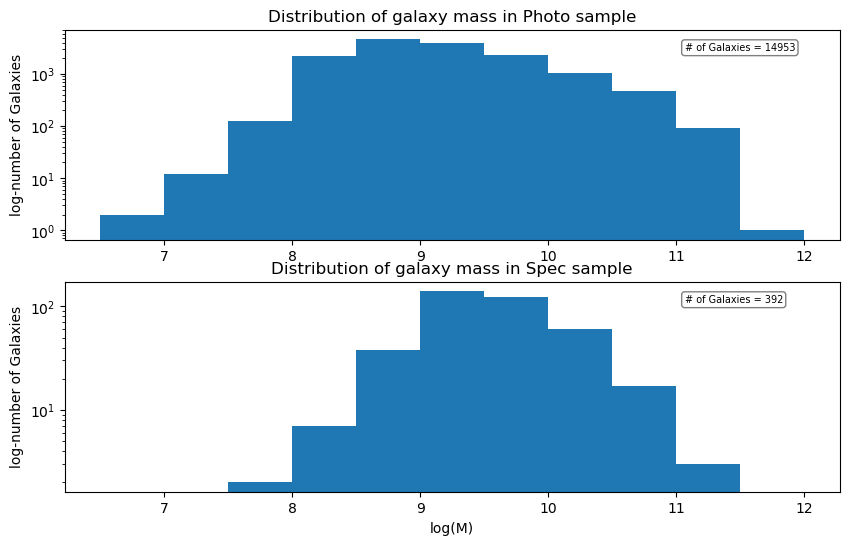

In [49]:
### C20 Phot stellar mass

fig,ax = plt.subplots(2,1)

fig.set_size_inches(10,6)

ax[0].hist(c20p["lp_mass_med"], bins=np.arange(6.5, 12.5, 0.5))
ax[0].set(yscale="log", ylabel="log-number of Galaxies", title="Distribution of galaxy mass in Photo sample")
bbox = dict(boxstyle='round', fc = "white", ec='k', alpha=0.5)
ax[0].text(0.8, 0.9, f"# of Galaxies = {c20p.shape[0]}", fontsize=7,
                    bbox=bbox,transform=ax[0].transAxes)

ax[1].hist(c20s[:,15], bins=np.arange(6.5, 12.5, 0.5))
ax[1].set(yscale="log", ylabel="log-number of Galaxies",xlabel="log(M)", title="Distribution of galaxy mass in Spec sample")
bbox = dict(boxstyle='round', fc = "white", ec='k', alpha=0.5)
ax[1].text(0.8, 0.9, f"# of Galaxies = {c20s.shape[0]}", fontsize=7,
                    bbox=bbox,transform=ax[1].transAxes)

plt.show()